In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

In [ ]:
data = pd.read_csv(r"vehicle_tracks_003.csv")

In [26]:
no_of_cars = data['track_id'].unique()
car_dict = {car_no: 0.00 for car_no in no_of_cars}

In [27]:
def generate_autonomous_car_data(timestamp, radius=15, speed=5.398298934, center=np.array([996, 999])):
    # Calculate the angular velocity needed for a circular motion
    angular_velocity = speed / radius  # rad/s
    
    # Calculate the current angle (theta) based on time and angular velocity
    theta = angular_velocity * timestamp  # angle in radians
    
    # Calculate the position on the circle at the current angle
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    
    # Calculate the velocity components (tangential to the circle)
    vx = -speed * np.sin(theta)  # derivative of x with respect to time
    vy = speed * np.cos(theta)   # derivative of y with respect to time
    
    # Calculate the heading angle (psi) as the direction of the velocity vector
    psi_rad = np.arctan2(vy, vx)
    
    return {'x': x, 'y': y, 'vx': vx, 'vy': vy, 'psi_rad': psi_rad}

In [28]:

grid_size = 30
radius = 15
fov = 120
angle_step = 0.05
total_steps = 500 

In [29]:
def create_grids(data, grid_size):
    data['grid_x'] = (data['x'] // grid_size).astype(int)
    data['grid_y'] = (data['y'] // grid_size).astype(int)
    return data

grid_radius = int(radius // grid_size)
def get_nearby_grids(autonomous_car, grid_size, radius):
    grid_x = int(autonomous_car['x'] // grid_size)
    grid_y = int(autonomous_car['y'] // grid_size)
    x_range = np.arange(grid_x - grid_radius, grid_x + grid_radius + 1)
    y_range = np.arange(grid_y - grid_radius, grid_y + grid_radius + 1)
    grids = np.array(np.meshgrid(x_range, y_range)).T.reshape(-1, 2)
    #grids = [(i, j) for i in range(grid_x - grid_radius, grid_x + grid_radius + 1)
    #                 for j in range(grid_y - grid_radius + 1)]
    return grids

In [30]:
def get_car_boundaries(car):
 
    center_x, center_y = car['x'], car['y']
    half_length = car['length']/2
    half_width = car['width']/2
    angle = np.arctan2(car['vy'], car['vx'])

    corners = np.array([
        [center_x - half_length * np.cos(angle) - half_width * np.sin(angle), 
         center_y - half_length * np.sin(angle) + half_width * np.cos(angle)],  # Top-left
        [center_x + half_length * np.cos(angle) - half_width * np.sin(angle), 
         center_y + half_length * np.sin(angle) + half_width * np.cos(angle)],  # Top-right
        [center_x + half_length * np.cos(angle) + half_width * np.sin(angle), 
         center_y + half_length * np.sin(angle) - half_width * np.cos(angle)],  # Bottom-right
        [center_x - half_length * np.cos(angle) + half_width * np.sin(angle), 
         center_y - half_length * np.sin(angle) - half_width * np.cos(angle)]   # Bottom-left
    ])


    return corners

In [31]:
def filter_cars_by_grid_and_fov(data, grids, autonomous_car, radius, fov, current_time):
    fov_half_angle = np.radians(fov) / 2
    data['relevant'] = False  # Whether the car is relevant (inside radius and FOV)
    
    for _, car in data.iterrows():
        car_id = car['track_id']
        corners = get_car_boundaries(car)  # Get car's boundary corners

        # Compute distances of all corners from the autonomous car
        distances = np.sqrt((corners[:, 0] - autonomous_car['x'])**2 + (corners[:, 1] - autonomous_car['y'])**2)

        # Compute car grids
        car_grids = [(int(x // grid_size), int(y // grid_size)) for x, y in corners]
        car_grids = list(set(car_grids))  # Remove duplicate grids

        # Check if car's grids overlap with nearby grids
        if any(grid in grids for grid in car_grids):
            # Check if the car is within the radius
            if np.any(distances <= radius):
                # Check if the car is within the FOV
                relative_angles = np.arctan2(corners[:, 1] - autonomous_car['y'], corners[:, 0] - autonomous_car['x'])
                car_angles = np.mod(relative_angles - autonomous_car['psi_rad'] + np.pi, 2 * np.pi) - np.pi

                if np.any(np.abs(car_angles) <= fov_half_angle):
                    data.at[car.name, 'relevant'] = True
                    continue  # Skip updating `car_dict` for relevant cars
            
        # **Fix: Ensure `distances` is always available**
        velocity = np.linalg.norm([car['vx'], car['vy']])  # Calculate speed
        if velocity > 0:
            min_time_to_reach = max(0, (np.min(distances) - radius) / velocity)
        else:
            min_time_to_reach = float('inf')  # Car is stationary

        # Update car_dict with the next eligible time
        car_dict[car_id] = current_time + min_time_to_reach

    # Return only relevant cars
    return data[data['relevant']]


# Discretize angles for efficient angle-based filtering
fov_half_angle = np.radians(fov) / 2
discrete_angles = np.arange(-fov_half_angle, fov_half_angle + np.radians(angle_step), np.radians(angle_step))
def discretize_angles(data, autonomous_car, angle_step):

    data = data.copy()
    data['discrete_angle'] = None
    
    for _, car in data.iterrows():
        corners = get_car_boundaries(car)
        relative_angles = np.arctan2(corners[:, 1] - autonomous_car['y'], corners[:, 0] - autonomous_car['x'])
        car_angles = (relative_angles - autonomous_car['psi_rad'] + np.pi)% (2 * np.pi) - np.pi

        if np.any(np.abs(car_angles) <= fov_half_angle):
            data.at[car.name, 'discrete_angle'] = np.digitize(car_angles[np.abs(car_angles) <= fov_half_angle], discrete_angles) * angle_step

    return data

In [32]:
angle_mult = 180 / np.pi
def get_angle(car_center, point):
    
    return np.arctan2(point[1] - car_center[1], point[0] - car_center[0]) * angle_mult

def is_perpendicular(car, autonomous_car):
    
    car_center = car['x'], car['y']
    center = autonomous_car['x'], autonomous_car['y']
    vector_to_center = np.array(car_center) - np.array(center)
    velocity_vector = np.array([car['vx'], car['vy']])
    dot_product = np.dot(vector_to_center, velocity_vector)
    return np.isclose(dot_product, 0, atol=1e-3)


def is_parallel(car, autonomous_car):
    
    center = autonomous_car['x'], autonomous_car['y']
    car_center = car['x'], car['y']
    vector_to_center = np.array(car_center) - np.array(center)
    vector_to_center = np.append(vector_to_center, 0)
    velocity_vector = np.array([car['vx'], car['vy'], 0])
    cross_product = np.cross(vector_to_center, velocity_vector)
    return np.isclose(cross_product[2], 0, atol=1e-3)

def line_intersection(p1, p2, q1, q2):

    # Line p1 -> p2: (x1, y1) to (x2, y2)
    # Line q1 -> q2: (x3, y3) to (x4, y4)
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = q1
    x4, y4 = q2
    
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    if np.isclose(denom, 0):  # Lines are parallel or coincident
        return None
    
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom
    
    # Check if intersection is within the segments
    if 0 <= t <= 1 and 0 <= u <= 1:
        intersection_x = x1 + t * (x2 - x1)
        intersection_y = y1 + t * (y2 - y1)
        return np.array([intersection_x, intersection_y])
    else:
        return None

def check_visibility(autonomous_car, other_cars, fov_angle, radius):
    visible_segments = []
    #print(f'type of other_cars is {type(other_cars)}')
    # Define FOV rays extending from the autonomous car
    fov_left_angle = autonomous_car['psi_rad'] - np.radians(fov_angle) / 2
    fov_right_angle = autonomous_car['psi_rad'] + np.radians(fov_angle) / 2
    center = autonomous_car['x'], autonomous_car['y']
    fov_left_ray = np.array([
        center,
        center + radius * np.array([np.cos(fov_left_angle), np.sin(fov_left_angle)])
    ])
    
    fov_right_ray = np.array([
        center,
        center + radius * np.array([np.cos(fov_right_angle), np.sin(fov_right_angle)])
    ])
    
    if len(other_cars) !=0:
        for _,car in other_cars.iterrows():
            #print(f'car type is {car}')
            corners = get_car_boundaries(car)
            visible_corners = []

            # Check which corners are inside the FOV
            for corner in corners:
                corner_angle = get_angle(center, corner)
                relative_angle = corner_angle - np.degrees(autonomous_car['psi_rad'])
                relative_angle = (relative_angle + 180) % 360 - 180

                if np.abs(relative_angle) <= fov_angle / 2:
                    visible_corners.append(corner)
            # Variables to store the nearest intersection points for each ray
            nearest_left_intersection = None
            nearest_right_intersection = None
            min_left_distance = float('inf')
            min_right_distance = float('inf')
            distances = np.linalg.norm(np.array(visible_corners) - np.array(center), axis=1)
            farthest_corner_idx = np.argmax(distances)
            visible_corners.pop(farthest_corner_idx)

            # If the entire car is not inside the FOV, find intersections with FOV rays
            if len(visible_corners) < 4:
                        for i in range(4):  # Iterate over car's edges (between corners)
                            p1 = corners[i]
                            p2 = corners[(i + 1) % 4]

                            # Check for intersection with FOV left ray
                            intersection_left = line_intersection(p1, p2, fov_left_ray[0], fov_left_ray[1])
                            if intersection_left is not None:
                                left_dist = np.linalg.norm(intersection_left - center)
                                if left_dist < min_left_distance:
                                    min_left_distance = left_dist
                                    nearest_left_intersection = intersection_left

                            # Check for intersection with FOV right ray
                            intersection_right = line_intersection(p1, p2, fov_right_ray[0], fov_right_ray[1])
                            if intersection_right is not None:
                                right_dist = np.linalg.norm(intersection_right - center)
                                if right_dist < min_right_distance:
                                    min_right_distance = right_dist
                                    nearest_right_intersection = intersection_right

                        # Store the nearest intersections (if any) to the visible corners
                        if nearest_left_intersection is not None:
                            visible_corners.append(nearest_left_intersection)
                        if nearest_right_intersection is not None:
                            visible_corners.append(nearest_right_intersection)
            # Now handle the visible corners as before
            if visible_corners:
                distances = np.linalg.norm(np.array(visible_corners) - np.array(center), axis=1)
                nearest_corner_idx = np.argmin(distances)
                nearest_corner = visible_corners[nearest_corner_idx]
                
                # Determine which segments to mark as visible
                if is_perpendicular(car, autonomous_car):
                    car_vel = np.arctan2(car['vy'], car['vx'])
                    if np.abs(get_angle(nearest_corner, visible_corners[(nearest_corner_idx + 1) % len(visible_corners)]) - (car_vel*180/np.pi)) < 1e-3:
                        i = 1
                    else:
                        i = -1
                    visible_segments.append((nearest_corner, visible_corners[(nearest_corner_idx + i) % len(visible_corners)]))
                elif is_parallel(car, autonomous_car):
                    car_vel = car['vx'], car['vy']
                    if np.abs(np.dot(nearest_corner - visible_corners[(nearest_corner_idx + 1) % len(visible_corners)], car_vel)) < 1e-3:
                        i = 1
                    else:
                        i = -1
                    visible_segments.append((nearest_corner, visible_corners[(nearest_corner_idx + i) % len(visible_corners)]))
                else:
                    # Shade two sides visible
                    next_corner_1 = visible_corners[(nearest_corner_idx + 1) % len(visible_corners)]
                    next_corner_2 = visible_corners[(nearest_corner_idx - 1) % len(visible_corners)]
                    visible_segments.append((nearest_corner, next_corner_1))
                    visible_segments.append((nearest_corner, next_corner_2))

    return visible_segments


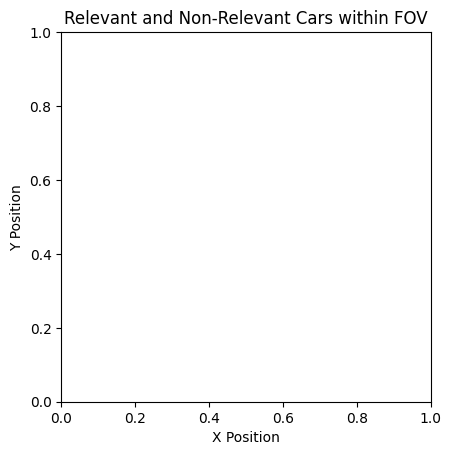

In [ ]:
# Initialize data
data = create_grids(data, grid_size)

# Plot setup
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Relevant and Non-Relevant Cars within FOV')

unique_timestamps = data['timestamp_ms'].unique()

# Function to plot each car as a rectangle
def plot_car(ax, car, is_relevant):
    corners = get_car_boundaries(car)
    polygon = plt.Polygon(corners, closed=True, edgecolor='red' if is_relevant else 'blue', facecolor='none')
    ax.add_patch(polygon)

# Update function for animation
#fov_lines = [ax.plot([], [], 'b--')[0] for _ in range(2)]
#autonomous_car_scatter = ax.scatter([], [], c='blue', label='Autonomous Car', s=10)
def update(frame):
    start_frame = time.time()
    step = frame
    current_time = unique_timestamps[frame]
    timestamp_data = data[data['timestamp_ms'] == current_time]
    filtered_data = []
    for _, car in timestamp_data.iterrows():
        car_id = car['track_id']
        if car_id in car_dict:
            if current_time < car_dict[car_id]:
                continue  # Skip cars not eligible for processing
        filtered_data.append(car)
    timestamp_data = pd.DataFrame(filtered_data)
    
    autonomous_car = generate_autonomous_car_data(step)
    nearby_grids = get_nearby_grids(autonomous_car, grid_size, radius)
    nearby_cars = filter_cars_by_grid_and_fov(timestamp_data, nearby_grids, autonomous_car, radius, fov, current_time)
    relevant_cars = discretize_angles(nearby_cars, autonomous_car, angle_step)
    # print(f'type of relevant_Cars is {type(relevant_cars)} and number of relevant cars = {len(relevant_cars)}')
    rel_cars_no.append(len(relevant_cars))
    ax.clear()
    
    # Plot autonomous car
    #autonomous_car_scatter.set_offsets([[autonomous_car['x'], autonomous_car['y']]])
    ax.scatter(autonomous_car['x'], autonomous_car['y'], c='blue', label='Autonomous Car', s=10)
    ax.set_title(step)
    # Draw FOV lines
    angle = autonomous_car['psi_rad']
    x, y = autonomous_car['x'], autonomous_car['y']
    fov_left = angle - np.radians(fov) / 2
    fov_right = angle + np.radians(fov) / 2

    #fov_lines[0].set_data([x, x + radius * np.cos(fov_left)], [y, y + radius * np.sin(fov_left)])
    #fov_lines[1].set_data([x, x + radius * np.cos(fov_right)], [y, y + radius * np.sin(fov_right)])
    ax.plot([x, x + radius * np.cos(fov_left)], [y, y + radius * np.sin(fov_left)], 'b--')
    ax.plot([x, x + radius * np.cos(fov_right)], [y, y + radius * np.sin(fov_right)], 'b--')
    
    ax.set_xlim(971,1021)
    ax.set_ylim(980, 1018)
    
    visible_segments = check_visibility(autonomous_car, relevant_cars, fov, radius)
    # Plot relevant cars
    for _, car in relevant_cars.iterrows():
        plot_car(ax, car, is_relevant=True)

    for seg in visible_segments:
        ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'g-', linewidth=1)


    # Plot non-relevant cars
    if 'track_id' in nearby_cars.columns:
        non_relevant_cars = nearby_cars[~nearby_cars['track_id'].isin(relevant_cars['track_id'])]
        for _, car in non_relevant_cars.iterrows():
            plot_car(ax, car, is_relevant=False)

    # plt.legend()
    plt.draw()
    # for _, car in timestamp_data.iterrows():
    #     car_id = car['track_id']
    #     position = np.array([car['x'], car['y']])
    #     velocity = np.linalg.norm([car['vx'], car['vy']])  # Calculate speed from velocity components
    #     distance = np.linalg.norm(position - np.array([autonomous_car['x'], autonomous_car['y']]))
    #     if distance < radius:
    #         continue  # Car is already within the radius
    #     if velocity > 0:
    #         min_time_to_reach = max(0, (distance - radius) / velocity)
    #     else:
    #         min_time_to_reach = float('inf')  # Car isn't moving, so it won't reach the radius

    #     car_dict[car_id] = current_time + min_time_to_reach
    end_frame = time.time()
    # print(f"Time taken to execute frame {frame} is {end_frame-start_frame}")
    times.append(end_frame-start_frame)




<Figure size 640x480 with 0 Axes>

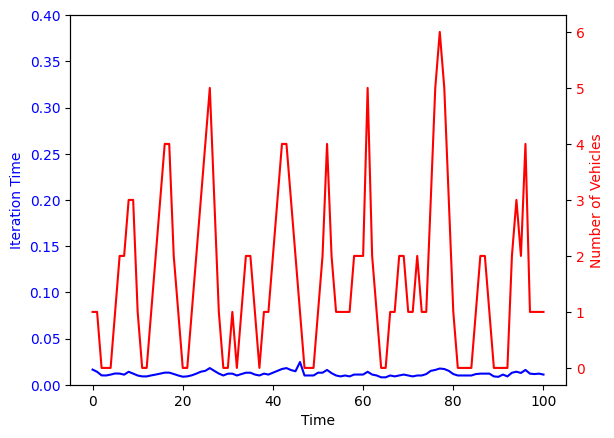

Average Frame Rate is 83.78956437703343


'\nMechanical Spinning LiDAR:\n\n    Frame rate: 5 Hz to 20 Hz (5 to 20 frames per second)\n    Example: The Velodyne HDL-32E provides output at around 10-20 Hz.\n    \n    Velodyne HDL-32E: A 360-degree spinning LiDAR with 32 laser channels. It has a frame rate of 10–20 Hz and a range of up to 100 meters.\n    Ouster OS1: Another popular spinning LiDAR with high-resolution output and 128 channels, with a frame rate \n    ranging from 10 Hz to 20 Hz.\n\nSolid-State LiDAR:\n\n    Frame rate: 10 Hz to 30 Hz or higher.\n    Solid-state LiDARs tend to have higher frame rates than spinning LiDARs due to fewer moving parts.\n    \n    InnovizOne: A solid-state LiDAR used in automotive applications, offering a 30 Hz frame rate and a range of up to 250 meters.\n    Luminar Hydra: Designed for autonomous driving, it provides long-range detection up to 250 meters with a frame rate of around\n    10-20 Hz, without any moving parts.\n\nFrequency-Modulated Continuous Wave (FMCW) LiDAR:\n\n    Frame

In [34]:
times = []
rel_cars_no =[]
# Animation creation
# start = time.time()
# for frame in range(len(unique_timestamps)):
#     update(frame)
ani = animation.FuncAnimation(fig, update, frames=len(unique_timestamps), interval=500, repeat=False)
ani.save('2D_cars_line_blue_red_testing.gif', writer = 'pillow')
# stop = time.time()
# print(f"Completed in {stop-start}")
fig1, ax1 = plt.subplots()

# Plotting the first dataset
ax1.plot(times, color="blue")
ax1.set_xlabel("Time")
ax1.set_ylabel("Iteration Time", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(0,0.40)

# Creating a second y-axis
ax2 = ax1.twinx()
ax2.plot(rel_cars_no, color="red")
ax2.set_ylabel("Number of Vehicles", color="red")
ax2.tick_params(axis="y", labelcolor="red")
plt.savefig(f"Plots/Testing.png")
plt.show()
# print(times)
print(f"Average Frame Rate is {len(times)/sum(times)}")
# print(f"Average cars per times stamp is {sum(rel_cars_no)/len(rel_cars_no)}")

# OBSERVATION: Average time for processing each time stamp is 0.04255377831150643 ~ 23.499Hz
# Default frequency used in Gazebo Simulations = 10Hz
'''
Mechanical Spinning LiDAR:

    Frame rate: 5 Hz to 20 Hz (5 to 20 frames per second)
    Example: The Velodyne HDL-32E provides output at around 10-20 Hz.
    
    Velodyne HDL-32E: A 360-degree spinning LiDAR with 32 laser channels. It has a frame rate of 10–20 Hz and a range of up to 100 meters.
    Ouster OS1: Another popular spinning LiDAR with high-resolution output and 128 channels, with a frame rate 
    ranging from 10 Hz to 20 Hz.

Solid-State LiDAR:

    Frame rate: 10 Hz to 30 Hz or higher.
    Solid-state LiDARs tend to have higher frame rates than spinning LiDARs due to fewer moving parts.
    
    InnovizOne: A solid-state LiDAR used in automotive applications, offering a 30 Hz frame rate and a range of up to 250 meters.
    Luminar Hydra: Designed for autonomous driving, it provides long-range detection up to 250 meters with a frame rate of around
    10-20 Hz, without any moving parts.

Frequency-Modulated Continuous Wave (FMCW) LiDAR:

    Frame rate: Variable, often around 15 Hz to 30 Hz or more, depending on the sensor.
    
    Aeva Aeries II: This FMCW LiDAR can detect velocity in addition to distance, operating with a frame rate around 15–30 Hz and a
    range of up to 300 meters.
    Silicon Valley-based Aurora: This company is developing FMCW LiDAR for autonomous vehicles, which is known for providing precise
    velocity measurements alongside distance at frame rates of 10–30 Hz.
    
'''